In [1]:
from  datetime import datetime, timedelta
import gc
import numpy as np, pandas as pd
import lightgbm as lgb

In [2]:
sales_train_validation = pd.read_csv('../data/sales_train_validation.csv')
increasing_term = sales_train_validation.groupby(['dept_id', 'store_id'])\
                [['d_%s' % c for c in range(1,1914)]].sum()
increasing_term = (increasing_term.T - increasing_term.T.shift(28))/increasing_term.T.shift(28)
increasing_term = increasing_term.reset_index(drop=True).iloc[-365:,:]
rates = increasing_term[increasing_term.abs()<1].mean()+1

In [3]:
rates = rates.reset_index().rename(columns={0:'rate'})

In [4]:
CAL_DTYPES = {
    "event_name_1": "category",
    "event_name_2": "category",
    "event_type_1": "category", 
    "event_type_2": "category",
    "weekday": "category",
    'wm_yr_wk': 'int16',
    "wday": "int16",
    "month": "int16",
    "year": "int16",
    "snap_CA": "float32",
    'snap_TX': 'float32',
    'snap_WI': 'float32' 
}
PRICE_DTYPES = {
    "store_id": "category",
    "item_id": "category",
    "wm_yr_wk": "int16",
    "sell_price":"float32"
}

In [5]:
pd.options.display.max_columns = 50

In [6]:
h = 28 
max_lags = 366
tr_last = 1913
fday = datetime(2016,4, 25) 
fday

datetime.datetime(2016, 4, 25, 0, 0)

In [7]:
def create_dt(is_train = True, nrows = None, first_day = 1200):
    prices = pd.read_csv("../data/sell_prices.csv", dtype = PRICE_DTYPES)
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            prices[col] = prices[col].cat.codes.astype("int16")
            prices[col] -= prices[col].min()
            
    cal = pd.read_csv("../data/calendar.csv", dtype = CAL_DTYPES)
    cal["date"] = pd.to_datetime(cal["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            cal[col] = cal[col].cat.codes.astype("int16")
            cal[col] -= cal[col].min()
    
    start_day = max(1 if is_train  else tr_last-max_lags, first_day)
    numcols = [f"d_{day}" for day in range(start_day,tr_last+1)]
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    dtype = {numcol:"float32" for numcol in numcols} 
    dtype.update({col: "category" for col in catcols if col != "id"})
    dt = pd.read_csv("../data/sales_train_validation.csv", 
                     nrows = nrows, usecols = catcols + numcols, dtype = dtype)
    
    for col in catcols:
        if col != "id":
            dt[col] = dt[col].cat.codes.astype("int16")
            dt[col] -= dt[col].min()
    
    increasing_term = dt.groupby(['dept_id', 'store_id'])[numcols].sum()
    increasing_term = (increasing_term.T - increasing_term.T.shift(28))/increasing_term.T.shift(28)
    increasing_term = increasing_term.reset_index(drop=True).iloc[-365:,:]
    rates = increasing_term[increasing_term.abs()<1].mean()+1
    rates = rates.reset_index().rename(columns={0:'rate'})
    
    if not is_train:
        for day in range(tr_last+1, tr_last+ 2*h +1):
            dt[f"d_{day}"] = np.nan
    
    dt = pd.melt(dt,
                  id_vars = catcols,
                  value_vars = [col for col in dt.columns if col.startswith("d_")],
                  var_name = "d",
                  value_name = "sales")
    
    dt = dt.merge(cal, on= "d", copy = False)
    dt = dt.merge(prices, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
    dt = dt.merge(rates, how='left')
    
    return dt

In [8]:
def create_fea(dt):
    lags = [7, 28]
    lag_cols = [f"lag_{lag}" for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        dt[lag_col] = dt[["id","sales"]].groupby("id")["sales"].shift(lag)

    wins = [7, 28]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            dt[f"rmean_{lag}_{win}"] = dt[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())

    
    
    date_features = {
        
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
#         "ime": "is_month_end",
#         "ims": "is_month_start",
    }
    
#     dt.drop(["d", "wm_yr_wk", "weekday"], axis=1, inplace = True)
    
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in dt.columns:
            dt[date_feat_name] = dt[date_feat_name].astype("int16")
        else:
            dt[date_feat_name] = getattr(dt["date"].dt, date_feat_func).astype("int16")

In [9]:
FIRST_DAY = 1 # If you want to load all the data set it to '1' -->  Great  memory overflow  risk !

In [10]:
%%time

df = create_dt(is_train=True, first_day= FIRST_DAY)
df.shape

CPU times: user 39.5 s, sys: 14.8 s, total: 54.3 s
Wall time: 54.3 s


(46027957, 23)

In [11]:
df.head()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,rate
0,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_1,12.0,2011-01-29,11101,2,1,1,2011,0,0,0,0,0.0,0.0,0.0,0.46,1.020196
1,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_2,15.0,2011-01-30,11101,3,2,1,2011,0,0,0,0,0.0,0.0,0.0,0.46,1.020196
2,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_3,0.0,2011-01-31,11101,1,3,1,2011,0,0,0,0,0.0,0.0,0.0,0.46,1.020196
3,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_4,0.0,2011-02-01,11101,5,4,2,2011,0,0,0,0,1.0,1.0,0.0,0.46,1.020196
4,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_5,0.0,2011-02-02,11101,6,5,2,2011,0,0,0,0,1.0,0.0,1.0,0.46,1.020196


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46027957 entries, 0 to 46027956
Data columns (total 23 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            object        
 1   item_id       int16         
 2   dept_id       int16         
 3   store_id      int16         
 4   cat_id        int16         
 5   state_id      int16         
 6   d             object        
 7   sales         float32       
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  weekday       int16         
 11  wday          int16         
 12  month         int16         
 13  year          int16         
 14  event_name_1  int16         
 15  event_type_1  int16         
 16  event_name_2  int16         
 17  event_type_2  int16         
 18  snap_CA       float32       
 19  snap_TX       float32       
 20  snap_WI       float32       
 21  sell_price    float32       
 22  rate          float32       
dtypes: datetime64[ns](1), float32(

In [13]:
%%time

create_fea(df)
df.shape

CPU times: user 3min 7s, sys: 19.4 s, total: 3min 27s
Wall time: 3min 27s


(46027957, 32)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46027957 entries, 0 to 46027956
Data columns (total 32 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            object        
 1   item_id       int16         
 2   dept_id       int16         
 3   store_id      int16         
 4   cat_id        int16         
 5   state_id      int16         
 6   d             object        
 7   sales         float32       
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  weekday       int16         
 11  wday          int16         
 12  month         int16         
 13  year          int16         
 14  event_name_1  int16         
 15  event_type_1  int16         
 16  event_name_2  int16         
 17  event_type_2  int16         
 18  snap_CA       float32       
 19  snap_TX       float32       
 20  snap_WI       float32       
 21  sell_price    float32       
 22  rate          float32       
 23  lag_7         float32       
 

In [15]:
df.head()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,rate,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday
0,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_1,12.0,2011-01-29,11101,2,1,1,2011,0,0,0,0,0.0,0.0,0.0,0.46,1.020196,NaN,NaN,NaN,NaN,NaN,NaN,4,1,29
1,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_2,15.0,2011-01-30,11101,3,2,1,2011,0,0,0,0,0.0,0.0,0.0,0.46,1.020196,NaN,NaN,NaN,NaN,NaN,NaN,4,1,30
2,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_3,0.0,2011-01-31,11101,1,3,1,2011,0,0,0,0,0.0,0.0,0.0,0.46,1.020196,NaN,NaN,NaN,NaN,NaN,NaN,5,1,31
3,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_4,0.0,2011-02-01,11101,5,4,2,2011,0,0,0,0,1.0,1.0,0.0,0.46,1.020196,NaN,NaN,NaN,NaN,NaN,NaN,5,1,1
4,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_5,0.0,2011-02-02,11101,6,5,2,2011,0,0,0,0,1.0,0.0,1.0,0.46,1.020196,NaN,NaN,NaN,NaN,NaN,NaN,5,1,2


In [16]:
df.dropna(inplace = True)
df.shape

(44351007, 32)

In [17]:
cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday", 'rate']
train_cols = df.columns[~df.columns.isin(useless_cols)]
X_train = df[train_cols]
y_train = df["sales"]

In [18]:
train_data = lgb.Dataset(X_train, label = y_train, categorical_feature=cat_feats, free_raw_data=False)

np.random.seed(seed=3105)
fake_valid_inds = np.random.choice(len(X_train), 1000000)

fake_valid_data = lgb.Dataset(X_train.iloc[fake_valid_inds], label = y_train.iloc[fake_valid_inds],categorical_feature=cat_feats,
                             free_raw_data=False)   # This is just a subsample of the training set, not a real validation set !

In [19]:
params = {
    "objective" : "poisson",
    "metric" :"rmse",
    "force_row_wise" : True,
    "learning_rate" : 0.075,
    "sub_feature" : 0.8,
    "sub_row" : 0.75,
    "bagging_freq" : 1,
    "lambda_l2" : 0.1,
    "nthread" : 16,
    "metric": ["rmse"],
    'verbosity': 1,
    'num_iterations' : 20000,
}

In [20]:
%%time

m_lgb = lgb.train(params, train_data, valid_sets = [fake_valid_data], verbose_eval=50,
                  early_stopping_rounds=100) 

/home/dataexmachina/.venv/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/dataexmachina/.venv/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 3.09492
[100]	valid_0's rmse: 2.65193
[150]	valid_0's rmse: 2.59121
[200]	valid_0's rmse: 2.50327
[250]	valid_0's rmse: 2.46405
[300]	valid_0's rmse: 2.43477
[350]	valid_0's rmse: 2.42032
[400]	valid_0's rmse: 2.40083
[450]	valid_0's rmse: 2.38175
[500]	valid_0's rmse: 2.37148
[550]	valid_0's rmse: 2.36381
[600]	valid_0's rmse: 2.35414
[650]	valid_0's rmse: 2.34568
[700]	valid_0's rmse: 2.33794
[750]	valid_0's rmse: 2.33072
[800]	valid_0's rmse: 2.32605
[850]	valid_0's rmse: 2.32118
[900]	valid_0's rmse: 2.31807
[950]	valid_0's rmse: 2.31394
[1000]	valid_0's rmse: 2.30984
[1050]	valid_0's rmse: 2.30731
[1100]	valid_0's rmse: 2.30439
[1150]	valid_0's rmse: 2.3013
[1200]	valid_0's rmse: 2.29769
[1250]	valid_0's rmse: 2.2952
[1300]	valid_0's rmse: 2.29251
[1350]	valid_0's rmse: 2.28879
[1400]	valid_0's rmse: 2.28602
[1450]	valid_0's rmse: 2.28376
[1500]	valid_0's rmse: 2.2812
[1550]	valid_0's rmse: 2.27944


[13150]	valid_0's rmse: 2.13725
[13200]	valid_0's rmse: 2.13688
[13250]	valid_0's rmse: 2.13657
[13300]	valid_0's rmse: 2.13627
[13350]	valid_0's rmse: 2.13601
[13400]	valid_0's rmse: 2.13583
[13450]	valid_0's rmse: 2.1356
[13500]	valid_0's rmse: 2.13544
[13550]	valid_0's rmse: 2.13498
[13600]	valid_0's rmse: 2.13472
[13650]	valid_0's rmse: 2.13438
[13700]	valid_0's rmse: 2.13391
[13750]	valid_0's rmse: 2.13364
[13800]	valid_0's rmse: 2.13341
[13850]	valid_0's rmse: 2.13299
[13900]	valid_0's rmse: 2.13285
[13950]	valid_0's rmse: 2.13249
[14000]	valid_0's rmse: 2.13231
[14050]	valid_0's rmse: 2.13207
[14100]	valid_0's rmse: 2.13177
[14150]	valid_0's rmse: 2.13133
[14200]	valid_0's rmse: 2.13095
[14250]	valid_0's rmse: 2.13071
[14300]	valid_0's rmse: 2.12991
[14350]	valid_0's rmse: 2.12981
[14400]	valid_0's rmse: 2.12963
[14450]	valid_0's rmse: 2.12949
[14500]	valid_0's rmse: 2.12922
[14550]	valid_0's rmse: 2.12903
[14600]	valid_0's rmse: 2.1282
[14650]	valid_0's rmse: 2.12794
[14700]	va

In [21]:
m_lgb.save_model('lgb.txt')

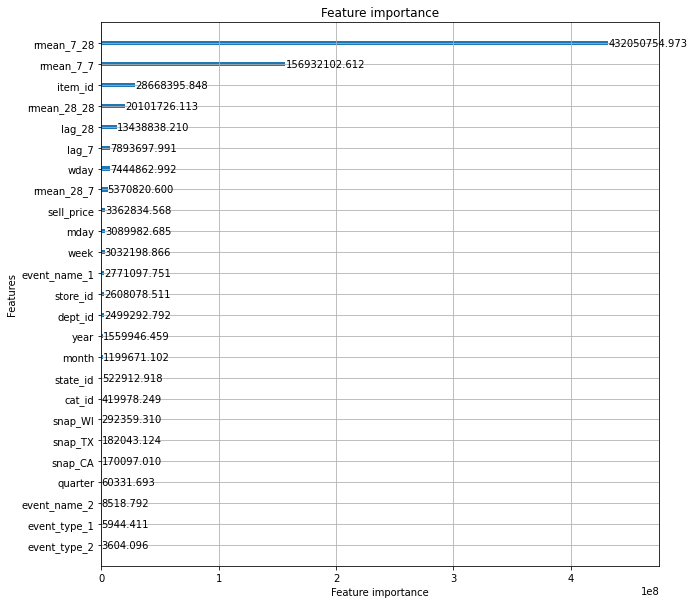

In [22]:
%matplotlib inline
lgb.plot_importance(m_lgb, figsize=(10,10), importance_type='gain')

In [23]:
%%time

te = create_dt(False)
te.shape

CPU times: user 13.2 s, sys: 5.17 s, total: 18.3 s
Wall time: 18.3 s


(12864391, 23)

In [24]:
train_cols.tolist()

['item_id',
 'dept_id',
 'store_id',
 'cat_id',
 'state_id',
 'wday',
 'month',
 'year',
 'event_name_1',
 'event_type_1',
 'event_name_2',
 'event_type_2',
 'snap_CA',
 'snap_TX',
 'snap_WI',
 'sell_price',
 'lag_7',
 'lag_28',
 'rmean_7_7',
 'rmean_28_7',
 'rmean_7_28',
 'rmean_28_28',
 'week',
 'quarter',
 'mday']

In [25]:
%%time

for i in range(0, 28):
    day = fday + timedelta(days=i)
    print(i, day)
    tst = te[(te.date >= day - timedelta(days=max_lags)) & (te.date <= day)].copy()
    create_fea(tst)
    tst = tst.loc[tst.date == day , train_cols.tolist()+['rate']]
    te.loc[te.date == day, "sales"] = tst['rate']*m_lgb.predict(tst[train_cols]) #1.02*m_lgb.predict(tst[train_cols]) # magic multiplier by kyakovlev

0 2016-04-25 00:00:00
1 2016-04-26 00:00:00
2 2016-04-27 00:00:00
3 2016-04-28 00:00:00
4 2016-04-29 00:00:00
5 2016-04-30 00:00:00
6 2016-05-01 00:00:00
7 2016-05-02 00:00:00
8 2016-05-03 00:00:00
9 2016-05-04 00:00:00
10 2016-05-05 00:00:00
11 2016-05-06 00:00:00
12 2016-05-07 00:00:00
13 2016-05-08 00:00:00
14 2016-05-09 00:00:00
15 2016-05-10 00:00:00
16 2016-05-11 00:00:00
17 2016-05-12 00:00:00
18 2016-05-13 00:00:00
19 2016-05-14 00:00:00
20 2016-05-15 00:00:00
21 2016-05-16 00:00:00
22 2016-05-17 00:00:00
23 2016-05-18 00:00:00
24 2016-05-19 00:00:00
25 2016-05-20 00:00:00
26 2016-05-21 00:00:00
27 2016-05-22 00:00:00
CPU times: user 3h 27min 33s, sys: 2min 56s, total: 3h 30min 29s
Wall time: 1h 3min 45s


In [26]:
%%time

te_sub = te.loc[te.date >= fday, ["id", "sales"]].copy()
te_sub.loc[te.date >= fday+ timedelta(days=h), "id"] = te_sub.loc[te.date >= fday+timedelta(days=h), 
                                                                      "id"].str.replace("validation$", "evaluation")
te_sub["F"] = [f"F{rank}" for rank in te_sub.groupby("id")["id"].cumcount()+1]
te_sub = te_sub.set_index(["id", "F" ]).unstack()["sales"][[f"F{i}" for i in range(1,29)]].reset_index()
te_sub.fillna(0., inplace = True)
te_sub.to_csv("lgb_full_adjusted_rates_2.csv",index=False)
te_sub.shape

CPU times: user 6.05 s, sys: 388 ms, total: 6.44 s
Wall time: 6.44 s


(60980, 29)

In [27]:
te_sub.head(10)

F,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,FOODS_1_001_CA_1_validation,0.871518,0.831305,0.840242,0.825771,1.088740,1.056254,1.095889,0.930839,0.927158,0.911595,0.848121,1.021479,1.223533,1.140665,0.887743,0.849529,0.859555,0.862183,0.973752,1.194397,1.102745,0.866276,0.790933,0.791407,0.810873,0.966150,1.127960,1.088883
2,FOODS_1_001_CA_2_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,FOODS_1_001_CA_2_validation,1.088962,1.142696,1.076801,1.276184,1.394750,1.394414,1.526905,1.047432,1.067924,1.041454,1.110036,1.281150,1.625336,1.571925,1.136511,1.154623,1.193682,1.214732,1.341948,1.793422,1.630641,1.230916,1.168040,1.184325,1.232669,1.465781,1.892918,1.648471
4,FOODS_1_001_CA_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,FOODS_1_001_CA_3_validation,1.051505,1.015790,0.998825,0.980193,1.058246,1.064947,1.071640,0.939695,1.018835,0.985451,0.921268,1.057494,1.331874,1.288923,1.047601,1.054396,1.035629,1.053504,1.121511,1.345794,1.255004,1.012228,0.991163,1.002380,1.021506,1.106855,1.271986,1.180227
6,FOODS_1_001_CA_4_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,FOODS_1_001_CA_4_validation,0.395988,0.363810,0.363674,0.372767,0.424516,0.392065,0.463920,0.376373,0.398752,0.396520,0.374508,0.403575,0.427168,0.431019,0.362682,0.374407,0.401172,0.405303,0.429395,0.456352,0.484394,0.378218,0.365389,0.373179,0.379628,0.441564,0.470697,0.471608
8,FOODS_1_001_TX_1_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,FOODS_1_001_TX_1_validation,0.198607,0.196174,0.196029,0.201065,0.213145,0.190352,0.233734,0.423772,0.375158,0.374712,0.378233,0.397997,0.448680,0.431420,0.364956,0.537393,0.376319,0.372563,0.391684,0.442739,0.444963,0.333124,0.327856,0.307426,0.309808,0.336337,0.403582,0.397399


In [28]:
te_sub.id.nunique()

60980